In [ ]:
# 1) Install only what's needed (avoid downgrading numpy/opencv)
!pip -q install insightface==0.7.3 onnxruntime==1.20.1 tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 29.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
[INFO] Insig

100%|██████████| 121/121 [01:42<00:00,  1.18it/s]


Done.
Saved crops: 119
Images with no accepted face: 2
Output: /content/cropped_faces


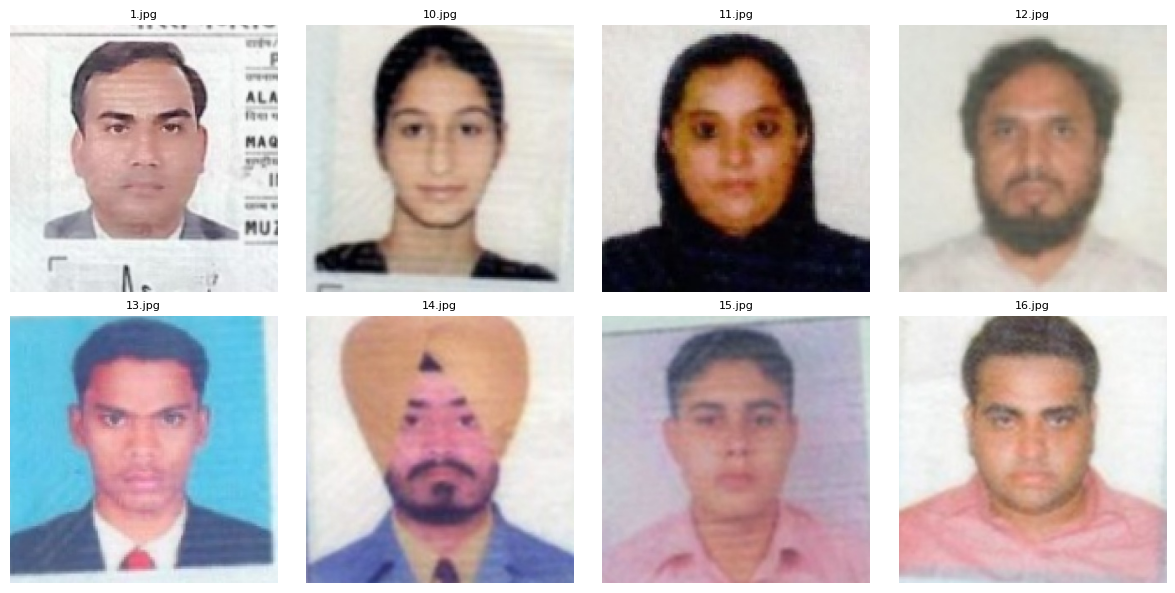

In [ ]:

# ==== Colab-Safe Face Cropper | InsightFace (SCRFD) ====
# Input:  /content/images
# Output: /content/cropped_faces
# Aligns by eyes, square-crops, resizes to 320x320.
# -------------------------------------------------------


import os, sys, math, warnings, subprocess
warnings.filterwarnings("ignore")

# Try to import cv2; if missing in image, install a compatible headless build.
try:
    import cv2
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "opencv-python-headless>=4.10.0.84"])
    import cv2

import numpy as np
from glob import glob
from tqdm import tqdm

# 2) InsightFace setup with SCRFD
import onnxruntime as ort
from insightface.app import FaceAnalysis

# If a GPU build of onnxruntime is present, it will advertise CUDAExecutionProvider.
use_gpu = "CUDAExecutionProvider" in ort.get_available_providers()
ctx_id = 0 if use_gpu else -1  # 0 -> GPU, -1 -> CPU

# You can raise det_size to (960,960) if faces are tiny (e.g., small ID thumbnails)
DET_SIZE = (640, 640)

app = FaceAnalysis(name="buffalo_l")  # bundle includes SCRFD detector and ArcFace; we only need detector+landmarks
app.prepare(ctx_id=ctx_id, det_size=DET_SIZE)
print(f"[INFO] InsightFace SCRFD ready. Backend: {'GPU (ORT CUDA)' if use_gpu else 'CPU'}")

# ---------- Config ----------
INPUT_DIR  = "/content/images"
OUTPUT_DIR = "/content/cropped_faces"
SAVE_ALL_FACES = False      # False: only largest face per image; True: save all faces
TARGET_SIZE = (320, 320)    # final (width, height)
ASPECT_W, ASPECT_H = 1, 1   # enforce square
MARGIN = 3                  # expand around face; try 0.40–0.45 for more shoulders/forehead
MIN_CROP_MIN_DIM = 40       # skip tiny crops
CONF_THRESHOLD = 0.5        # minimum detection score to keep a face
# ----------------------------

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Geometry helpers ----------
def rotate_align(image, kps):
    """
    Align image so eyes are horizontal using 5-point landmarks.
    kps order (insightface): [left_eye, right_eye, nose, left_mouth, right_mouth]
    """
    kps = np.asarray(kps, dtype=np.float32)
    left_eye, right_eye = kps[0], kps[1]
    dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
    angle = math.degrees(math.atan2(dy, dx))
    center = ((left_eye[0] + right_eye[0]) / 2.0, (left_eye[1] + right_eye[1]) / 2.0)
    M = cv2.getRotationMatrix2D((float(center[0]), float(center[1])), angle, 1.0)
    h, w = image.shape[:2]
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    # transform landmarks
    kps_h = np.hstack([kps, np.ones((kps.shape[0], 1), dtype=np.float32)])  # (5,3)
    kps_rot = (M @ kps_h.T).T
    return rotated, kps_rot

def bbox_from_landmarks(kps, scale=MARGIN):
    x_min, y_min = np.min(kps, axis=0)
    x_max, y_max = np.max(kps, axis=0)
    cx, cy = (x_min + x_max) / 2.0, (y_min + y_max) / 2.0
    w, h = (x_max - x_min), (y_max - y_min)
    w *= (1 + scale)
    h *= (1 + scale * 1.2)  # a bit more vertical room (forehead/chin)
    return [cx - w/2, cy - h/2, cx + w/2, cy + h/2]

def enforce_aspect_and_pad(img, box, aspect=(ASPECT_W, ASPECT_H)):
    """
    Expand the shorter side to match target aspect, pad out-of-bounds with replicate, then crop.
    """
    h, w = img.shape[:2]
    x1, y1, x2, y2 = map(float, box)
    bw, bh = x2 - x1, y2 - y1
    target_ratio = aspect[0] / aspect[1]
    curr_ratio = (bw / bh) if bh > 1e-6 else target_ratio

    if curr_ratio > target_ratio:
        # too wide -> increase height
        new_bh = bw / target_ratio
        delta = (new_bh - bh) / 2.0
        y1 -= delta; y2 += delta
    else:
        # too tall -> increase width
        new_bw = bh * target_ratio
        delta = (new_bw - bw) / 2.0
        x1 -= delta; x2 += delta

    # pad out-of-bounds with replicate
    left_pad   = max(0, int(-np.floor(x1)))
    top_pad    = max(0, int(-np.floor(y1)))
    right_pad  = max(0, int(np.ceil(x2) - w))
    bottom_pad = max(0, int(np.ceil(y2) - h))

    if any([left_pad, top_pad, right_pad, bottom_pad]):
        img = cv2.copyMakeBorder(img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_REPLICATE)
        x1 += left_pad; x2 += left_pad
        y1 += top_pad;  y2 += top_pad

    x1i, y1i, x2i, y2i = map(lambda v: int(round(v)), [x1, y1, x2, y2])
    x1i = max(0, x1i); y1i = max(0, y1i)
    x2i = min(img.shape[1], x2i); y2i = min(img.shape[0], y2i)
    crop = img[y1i:y2i, x1i:x2i]
    return crop

def face_area(face):
    x1, y1, x2, y2 = face.bbox.astype(float)
    return max(0.0, (x2 - x1)) * max(0.0, (y2 - y1))

# ---------- Processing with SCRFD ----------
def process_with_scrfd(img):
    faces = app.get(img)
    faces = [f for f in faces if getattr(f, "det_score", 1.0) >= CONF_THRESHOLD]
    if not faces:
        return []

    faces = sorted(faces, key=face_area, reverse=True)
    chosen = faces if SAVE_ALL_FACES else [faces[0]]
    outputs = []

    for f in chosen:
        kps = getattr(f, "kps", None)
        if kps is not None and np.array(kps).shape == (5,2):
            aligned, kps_rot = rotate_align(img, kps)
            box = bbox_from_landmarks(kps_rot, scale=MARGIN)
            crop = enforce_aspect_and_pad(aligned, box, aspect=(ASPECT_W, ASPECT_H))
        else:
            # Fallback to bbox if landmarks missing (rare for SCRFD)
            x1, y1, x2, y2 = f.bbox.astype(float)
            cx, cy = (x1 + x2) / 2.0, (y1 + y2) / 2.0
            bw, bh = (x2 - x1), (y2 - y1)
            bw *= (1 + MARGIN); bh *= (1 + MARGIN * 1.2)
            box = [cx - bw/2.0, cy - bh/2.0, cx + bw/2.0, cy + bh/2.0]
            crop = enforce_aspect_and_pad(img, box, aspect=(ASPECT_W, ASPECT_H))

        if crop is not None and min(crop.shape[:2]) >= MIN_CROP_MIN_DIM:
            outputs.append(cv2.resize(crop, TARGET_SIZE, interpolation=cv2.INTER_AREA))

    return outputs

# ---------- Process folder ----------
paths = sorted(
    [p for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp","*.tif","*.tiff")
     for p in glob(os.path.join(INPUT_DIR, ext))]
)

print(f"Found {len(paths)} images in {INPUT_DIR}")
saved = 0
skipped = 0
for p in tqdm(paths):
    img = cv2.imread(p)
    if img is None:
        skipped += 1
        continue

    crops = process_with_scrfd(img)

    base = os.path.splitext(os.path.basename(p))[0]
    if not crops:
        skipped += 1
        continue
    if len(crops) == 1:
        out_path = os.path.join(OUTPUT_DIR, f"{base}.jpg")
        cv2.imwrite(out_path, crops[0]); saved += 1
    else:
        for i, c in enumerate(crops, start=1):
            out_path = os.path.join(OUTPUT_DIR, f"{base}_{i}.jpg")
            cv2.imwrite(out_path, c); saved += 1

print(f"Done.\nSaved crops: {saved}\nImages with no accepted face: {skipped}\nOutput: {OUTPUT_DIR}")

# ---------- Preview ----------
import matplotlib.pyplot as plt
sample_outs = sorted(glob(os.path.join(OUTPUT_DIR, "*.jpg")))[:8]
if sample_outs:
    cols = 4
    rows = int(np.ceil(len(sample_outs)/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(sample_outs, 1):
        im = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i)
        plt.imshow(im); plt.title(os.path.basename(p), fontsize=8); plt.axis('off')
    plt.tight_layout(); plt.show()
else:
    print("No output previews available yet.")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ValueError: Mountpoint must not already contain files

In [ ]:
DRIVE_FOLDER_NAME = "all_cropped_faces_ind_pak_margin_3" # @param {type:"string"}

# Create the target directory in Google Drive if it doesn't exist
output_drive_path = os.path.join("/content/gdrive/MyDrive", DRIVE_FOLDER_NAME)
os.makedirs(output_drive_path, exist_ok=True)

print(f"Google Drive folder created/ready: {output_drive_path}")

Google Drive folder created/ready: /content/gdrive/MyDrive/all_cropped_faces_ind_pak_margin_3


In [ ]:
import shutil

source_dir = "/content/cropped_faces"
target_dir = os.path.join("/content/gdrive/MyDrive", DRIVE_FOLDER_NAME)

# Get list of files to copy
files_to_copy = glob(os.path.join(source_dir, "*.jpg"))

if not files_to_copy:
    print(f"No cropped faces found in {source_dir} to copy.")
else:
    for file_path in tqdm(files_to_copy, desc="Copying files to Google Drive"):
        shutil.copy(file_path, target_dir)
    print(f"Copied {len(files_to_copy)} files to {target_dir}")

Copying files to Google Drive: 100%|██████████| 116/116 [00:00<00:00, 6111.30it/s]

Copied 116 files to /content/gdrive/MyDrive/all_cropped_faces_ind_pak_margin_3
